# ConditionalGAN

## Importing the libraries and dependencies and drive
The following cell block imports all the libraries, functions, methods that are being used inn this jupyter notebook.<br>
The Deep Learning/Machine Learning Libarary being used here is the high level keras API of tensorflow 2.X.<Br>
And the plotting is done with matplotlib or seaborn plotting packages.

Along with this all the constants that will be common throughout the file are defined and declared here.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random, math, os, pickle, random, librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from itertools import combinations
%matplotlib inline

EPOCHS = 200
BATCH_SIZE = 128
IMG_SIZE = (28,28)
SEED = 100
CLASSES = 10
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.98

## Loading Data
The following block of code loads MNIST data in two formats.
- First is through the dataset module from keras which loads data in numpy arrays.
- Second is the TFDS - Tensorflow dataset module which loads data in the format of tenorflow_dataset whic makes it fast o process and load data onto and away from the memory(GPU/CPU)

I experimented with both the above techniques but the second one was very fast and thats what i am sticking with.
As it loads the next batch of data onto GPU memory while the current batch is being operated on - this is done with the prefetching functionality of the tensirflow_dataset module.

In [2]:
# df_train, df_test = tf.keras.datasets.mnist.load_data()

(df_train, df_test), df_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files = False,
    with_info = True,
    as_supervised = True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
df_info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

## Labels for the data & Look at the data

In [4]:
{df_info.features['label'].str2int(x):x for x in df_info.features['label'].names}

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

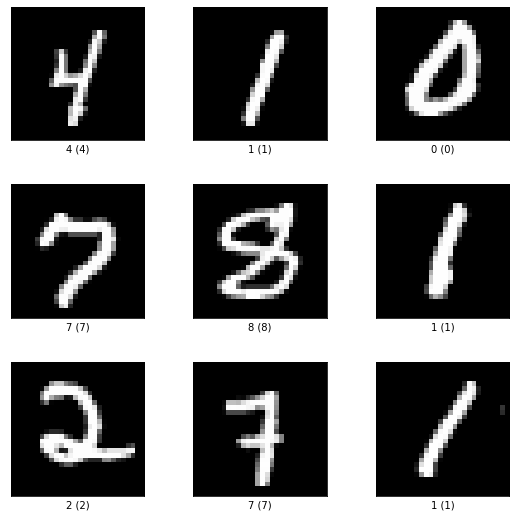

In [5]:
fig = tfds.show_examples(df_train, df_info)

In [36]:
(train_imgs, train_labels), (test_imgs, test_labels) = tf.keras.datasets.mnist.load_data()
train_imgs = 2*((train_imgs/255.)-0.5)
test_imgs = 2*((test_imgs/255.)-0.5)
train_imgs_pri = train_imgs.copy()

In [37]:
def preprocess(imgs, labels):
    df = np.empty((imgs.shape[0], 100))
    df2 = np.empty((imgs.shape[0], 784))
    for i in range(imgs.shape[0]):
        df[i, :] = imgs[i,10:20, 10:20].flatten()
        df2[i, :] = imgs[i, :, :].flatten()
    return df, df2, np.eye(10)[labels]

preprocess_train_imgs, train_imgs, train_labels = preprocess(train_imgs, train_labels)

In [38]:
preprocess_train_imgs.shape, train_imgs.shape, train_labels.shape

((60000, 100), (60000, 784), (60000, 10))

## Model Architecture

In [48]:
def Conditional_Gan(random_vec_size = 100, img_size = 784, cond_vec = 100, 
                    kernel_ini = 'HeNormal', activation_fn = tf.keras.layers.LeakyReLU(alpha=0.2)):
    encoder_inp = tf.keras.layers.Input(shape = (random_vec_size + cond_vec))
    # decoder_inp = tf.keras.layers.Input(shape = (img_size + cond_vec))
    decoder_inp = tf.keras.layers.Input(shape = (img_size))

    # Generator - Encoder
    en_layer = tf.keras.layers.Dense(200, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(encoder_inp)
    en_layer = tf.keras.layers.BatchNormalization(momentum=0.8)(en_layer)
    en_layer = tf.keras.layers.Dropout(0.1)(en_layer)
    en_layer = tf.keras.layers.Dense(400, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(encoder_inp)
    en_layer = tf.keras.layers.BatchNormalization(momentum=0.8)(en_layer)
    en_layer = tf.keras.layers.Dropout(0.1)(en_layer)
    en_layer = tf.keras.layers.Dense(800, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(encoder_inp)
    en_layer = tf.keras.layers.BatchNormalization(momentum=0.8)(en_layer)
    en_layer = tf.keras.layers.Dropout(0.1)(en_layer)

    # en_layer = tf.keras.layers.Dense(200, activation = 'relu')(en_layer)
    # en_layer = tf.keras.layers.Dropout(0.1)(en_layer)
    en_layer = tf.keras.layers.Dense(400, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(en_layer)
    en_layer = tf.keras.layers.BatchNormalization(momentum=0.8)(en_layer)
    en_layer = tf.keras.layers.Dropout(0.1)(en_layer)
    
    en_layer_out = tf.keras.layers.Dense(784, activation='tanh', kernel_initializer=kernel_ini)(en_layer)

    # Discriminator - Decoder
    de_layer = tf.keras.layers.Dense(784, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(decoder_inp)
    de_layer = tf.keras.layers.Dropout(0.2)(de_layer)

    de_layer = tf.keras.layers.Dense(400, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(de_layer)
    de_layer = tf.keras.layers.Dropout(0.2)(de_layer)

    de_layer = tf.keras.layers.Dense(200, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(de_layer)
    de_layer = tf.keras.layers.Dropout(0.2)(de_layer)

    de_layer = tf.keras.layers.Dense(100, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(de_layer)
    de_layer_out = tf.keras.layers.Dense(1,activation='sigmoid',
                                         kernel_initializer='GlorotNormal')(de_layer)

    encoder = tf.keras.models.Model(inputs = encoder_inp, outputs = en_layer_out)
    # encoder.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    #                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002),
    #                 metrics = ['accuracy'])

    decoder = tf.keras.models.Model(inputs = decoder_inp, outputs = de_layer_out)
    # decoder.compile(loss = 'binary_crossentropy',
    #                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002),
    #                 metrics = ['binary_accuracy'])
    
    return encoder, decoder

generator, discriminator = Conditional_Gan()
def get_random_batch(imgs, lbls, processed_imgs, idx, batch_size = 100):

    imgs_batch = imgs[idx:idx+batch_size]
    processed_imgs = processed_imgs[idx:idx+batch_size]
    lbls_batch = lbls[idx:idx+batch_size]
    
    return imgs_batch, processed_imgs, lbls_batch

## Custom training function & Training

In [49]:
# Help from keras documentation

class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim, batch_size, lammbda = 0.1):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.lammbda = lammbda
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]#, self.disc_acc_tracker, self.gen_acc_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn, mse_loss_fn, acc):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.mse_loss_fn = mse_loss_fn
        self.acc = acc

    def train_step(self, imgs):
        batch_size = tf.shape(imgs)[0]

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), dtype=tf.float64)
        # print(imgs.shape)
        labels = tf.cast(tf.reshape(imgs[:,10:20,10:20], shape=(-1, 100)), tf.float64)
        random_vector_labels = tf.concat(
            [random_latent_vectors, labels], axis=1
        )
        generated_images = tf.cast(self.generator(random_vector_labels), tf.float64)

        dis_labels_real = tf.ones((batch_size, 1))
        dis_labels_fake = tf.zeros((batch_size, 1))

        # Train the discriminator.
        self.discriminator.trainable = True
        with tf.GradientTape() as tape:
            predictions = self.discriminator(tf.reshape(imgs, (-1,784)))
            d_loss1 = self.loss_fn(dis_labels_real, predictions)
            predictions = self.discriminator(generated_images)
            d_loss2 = self.loss_fn(dis_labels_fake, predictions)
            d_loss = d_loss1 + d_loss2
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        # for _ in range(5):
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), dtype=tf.float64)
        labels = tf.cast(tf.reshape(imgs[:,10:20,10:20], shape=(-1, 100)), tf.float64)
        random_vector_labels = tf.concat(
            [random_latent_vectors, labels], axis=1
        )
        misleading_labels = tf.ones((batch_size, 1))
            
        # Train the Generator
        self.discriminator.trainable = False
        with tf.GradientTape() as tape:
            fake_images = tf.cast(self.generator(random_vector_labels), tf.float64)
            predictions = self.discriminator(fake_images)
            g_loss = tf.cast(self.loss_fn(misleading_labels, predictions), tf.float64)
            mse_g_loss = tf.cast(self.mse_loss_fn(random_latent_vectors, labels), tf.float64)
            # mse_g_loss = tf.cast(self.mse_loss_fn(tf.reshape(imgs, (-1,784)), fake_images), tf.float64)
            g_loss = g_loss + self.lammbda*mse_g_loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=100, batch_size =100, lammbda = 100
)
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(0.0001, 0.5),
    g_optimizer=tf.keras.optimizers.Adam(0.0001, 0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
    mse_loss_fn = tf.keras.losses.MSE,
    acc = tf.keras.metrics.Accuracy()
)
cond_gan.fit(train_imgs_pri, epochs=100, batch_size = 100)

Epoch 1/100
600/600 [==============================] - 6s 7ms/step - g_loss: 51.8162 - d_loss: 0.4925
Epoch 2/100
600/600 [==============================] - 4s 7ms/step - g_loss: 20.6595 - d_loss: 0.4679
Epoch 3/100
600/600 [==============================] - 4s 6ms/step - g_loss: 18.4579 - d_loss: 0.5334
Epoch 4/100
600/600 [==============================] - 4s 7ms/step - g_loss: 17.1900 - d_loss: 0.5812
Epoch 5/100
600/600 [==============================] - 4s 7ms/step - g_loss: 16.5255 - d_loss: 0.6185
Epoch 6/100
600/600 [==============================] - 4s 6ms/step - g_loss: 15.9431 - d_loss: 0.6343
Epoch 7/100
600/600 [==============================] - 4s 6ms/step - g_loss: 15.5651 - d_loss: 0.6367
Epoch 8/100
600/600 [==============================] - 4s 7ms/step - g_loss: 15.3557 - d_loss: 0.6354
Epoch 9/100
600/600 [==============================] - 4s 7ms/step - g_loss: 15.0482 - d_loss: 0.6479
Epoch 10/100
600/600 [==============================] - 4s 7ms/step - g_loss: 14.8

The above training is only shown for lambda = 100 for rest i have converted it into plots

## Plotting & Observations
- When lambda is 0.1 the digits being generated is random
- When the lambda is the 10 & 100 getting pretty good results, something similar to professors

For Lambda 0.1


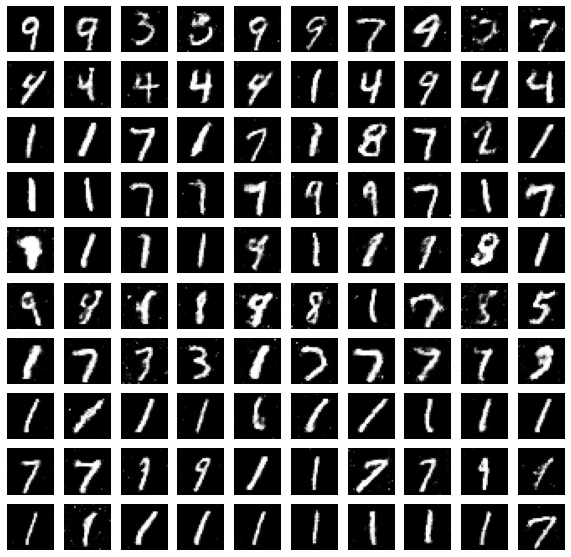

In [44]:
def plot_images(data, labels, mod, lammbda):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        indexes = np.where(labels == i)[0][:10]
        df = np.array([data[idx] for idx in indexes])
        df_labels = np.array([labels[idx] for idx in indexes])
        processed_df, df, lbls = preprocess(df, df_labels)
        for j in range(10):
            ax=plt.subplot2grid((10, 10), (i, j))
            z = np.random.normal(0,1,(1, 100))
            gen_image = mod.predict(np.concatenate([z, np.expand_dims(processed_df[j], 0)], axis=1))
            gen_image = 0.5*gen_image + 0.5
            try:
                ax.imshow(gen_image.reshape((28,28)), cmap='gray')
            except:
                pass
            plt.axis('off')
    print(f"For Lambda {lammbda}")
    plt.show()

plot_images(train_imgs_pri, np.argmax(train_labels, 1), cond_gan.generator, 0.1)

For Lambda 10


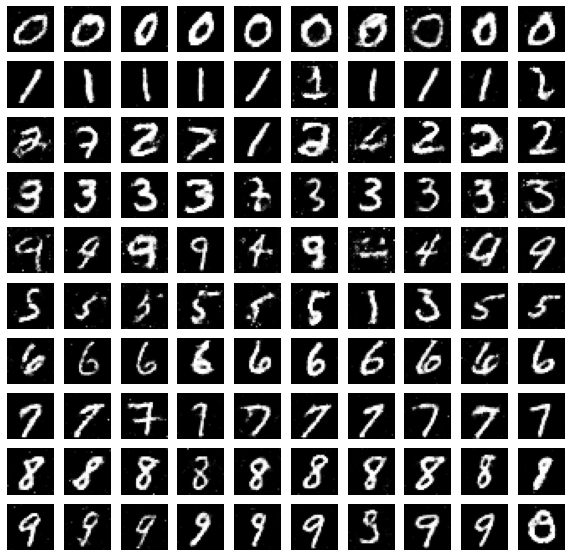

In [41]:
def plot_images(data, labels, mod, lammbda):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        indexes = np.where(labels == i)[0][:10]
        df = np.array([data[idx] for idx in indexes])
        df_labels = np.array([labels[idx] for idx in indexes])
        processed_df, df, lbls = preprocess(df, df_labels)
        for j in range(10):
            ax=plt.subplot2grid((10, 10), (i, j))
            z = np.random.normal(0,1,(1, 100))
            gen_image = mod.predict(np.concatenate([z, np.expand_dims(processed_df[j], 0)], axis=1))
            gen_image = 0.5*gen_image + 0.5
            try:
                ax.imshow(gen_image.reshape((28,28)), cmap='gray')
            except:
                pass
            plt.axis('off')
    print(f"For Lambda {lammbda}")
    plt.show()

plot_images(train_imgs_pri, np.argmax(train_labels, 1), cond_gan.generator, 10)

For Lambda 100


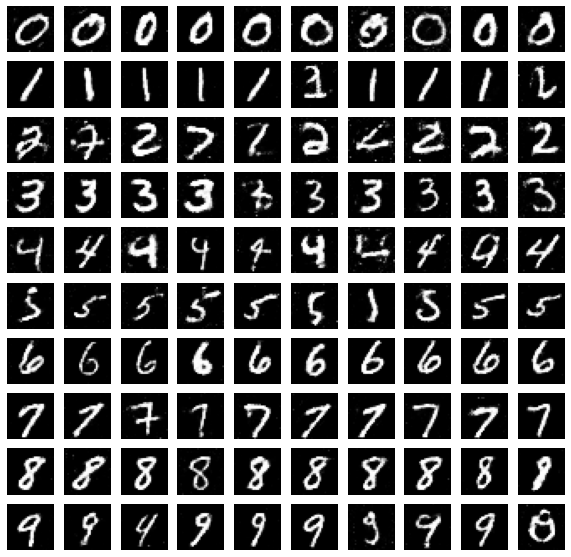

In [50]:
def plot_images(data, labels, mod, lammbda):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        indexes = np.where(labels == i)[0][:10]
        df = np.array([data[idx] for idx in indexes])
        df_labels = np.array([labels[idx] for idx in indexes])
        processed_df, df, lbls = preprocess(df, df_labels)
        for j in range(10):
            ax=plt.subplot2grid((10, 10), (i, j))
            z = np.random.normal(0,1,(1, 100))
            gen_image = mod.predict(np.concatenate([z, np.expand_dims(processed_df[j], 0)], axis=1))
            gen_image = 0.5*gen_image + 0.5
            try:
                ax.imshow(gen_image.reshape((28,28)), cmap='gray')
            except:
                pass
            plt.axis('off')
    print(f"For Lambda {lammbda}")
    plt.show()

plot_images(train_imgs_pri, np.argmax(train_labels, 1), cond_gan.generator, 100)

## Additional part - Custom training method

In [51]:
def Conditional_Gan(random_vec_size = 100, img_size = 784, cond_vec = 100, 
                    kernel_ini = 'HeNormal', activation_fn = tf.keras.layers.LeakyReLU(alpha=0.2)):
    encoder_inp = tf.keras.layers.Input(shape = (random_vec_size + cond_vec))
    decoder_inp = tf.keras.layers.Input(shape = (img_size + cond_vec))

    # Generator - Encoder
    en_layer = tf.keras.layers.Dense(200, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(encoder_inp)
    en_layer = tf.keras.layers.BatchNormalization(momentum=0.8)(en_layer)
    en_layer = tf.keras.layers.Dropout(0.1)(en_layer)

    # en_layer = tf.keras.layers.Dense(200, activation = 'relu')(en_layer)
    # en_layer = tf.keras.layers.Dropout(0.1)(en_layer)
    en_layer = tf.keras.layers.Dense(400, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(en_layer)
    en_layer = tf.keras.layers.BatchNormalization(momentum=0.8)(en_layer)
    en_layer = tf.keras.layers.Dropout(0.1)(en_layer)
    
    en_layer_out = tf.keras.layers.Dense(784, activation='tanh', kernel_initializer=kernel_ini)(en_layer)

    # Discriminator - Decoder
    de_layer = tf.keras.layers.Dense(884, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(decoder_inp)
    de_layer = tf.keras.layers.Dropout(0.2)(de_layer)

    de_layer = tf.keras.layers.Dense(400, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(de_layer)
    de_layer = tf.keras.layers.Dropout(0.2)(de_layer)

    de_layer = tf.keras.layers.Dense(200, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(de_layer)
    de_layer = tf.keras.layers.Dropout(0.2)(de_layer)

    de_layer = tf.keras.layers.Dense(100, activation = activation_fn, 
                                     kernel_initializer=kernel_ini)(de_layer)
    de_layer_out = tf.keras.layers.Dense(1,activation='sigmoid',
                                         kernel_initializer='GlorotNormal')(de_layer)

    encoder = tf.keras.models.Model(inputs = encoder_inp, outputs = en_layer_out)
    # encoder.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    #                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002),
    #                 metrics = ['accuracy'])

    decoder = tf.keras.models.Model(inputs = decoder_inp, outputs = de_layer_out)
    decoder.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002),
                    metrics = ['binary_accuracy'])
    
    return encoder, decoder

generator, discriminator = Conditional_Gan()

In [52]:
def get_random_batch(imgs, lbls, processed_imgs, idx, batch_size = 100):

    imgs_batch = imgs[idx:idx+batch_size]
    processed_imgs = processed_imgs[idx:idx+batch_size]
    lbls_batch = lbls[idx:idx+batch_size]
    
    return imgs_batch, processed_imgs, lbls_batch 

def build_gan(generator, discriminator, latent_dim = 100, lambda_mse = 0.1):
    rand_data = tf.keras.layers.Input(shape=(latent_dim,))
    cond_vec = tf.keras.layers.Input(shape=(100,))

    gen_inp = tf.keras.layers.concatenate([rand_data, cond_vec])
    features = generator(gen_inp)

    dis_inp = tf.keras.layers.concatenate([features, cond_vec])
    output = discriminator(dis_inp)
    
    discriminator.trainable = False
    
    model = tf.keras.models.Model([rand_data, cond_vec], outputs = output)
    model.compile(loss= ['binary_crossentropy','mse'],
                  loss_weights = [1,lambda_mse], 
                  optimizer = tf.keras.optimizers.Adam(0.0002,0.5))
    return model

gan = build_gan(generator, discriminator, lambda_mse = 0.1)

In [53]:
from collections import Counter

def train(epochs=20,   
          batch_size=100, 
          latent_dim = 100):
    real_accs, fake_accs = [], []
    gen_losses, d_losses = [], []
    
    for epoch in range(epochs):
        epoch_real_acc, epoch_fake_acc = [], []
        epoch_gen_losses, epoch_d_losses = [], []

        for i in range(0, len(train_imgs),
                       batch_size):
            discriminator.trainable = True
            
            img, processed_imgs, labels = get_random_batch(train_imgs, 
                                                           train_labels, 
                                                           preprocess_train_imgs, i)
            real_dis_loss, real_dis_acc = discriminator.train_on_batch(np.concatenate([img, processed_imgs], axis=1), 
                                                                              np.ones(shape= (batch_size, 1)))
            epoch_real_acc.append(real_dis_acc)
            # print("Real Acc:",real_dis_acc)

            z = np.random.normal(size = (batch_size, latent_dim))
            gen_img = generator.predict(np.concatenate([z, processed_imgs], axis=1))

            fake_dis_loss, fake_dis_acc = discriminator.train_on_batch(np.concatenate([gen_img, processed_imgs], axis=1), 
                                                                              np.zeros(shape = (batch_size,1)))
            epoch_fake_acc.append(fake_dis_acc)
            # print("Fake Acc:",fake_dis_acc)

            d_loss=(real_dis_loss + fake_dis_loss)/2
            epoch_d_losses.append(d_loss)

            discriminator.trainable = False
            z = np.random.normal(0,1,size = (batch_size, latent_dim))

            g_loss = gan.train_on_batch([z, processed_imgs], 
                                        np.ones(shape= (batch_size, 1)))
            epoch_gen_losses.append(g_loss)
            
            # x = np.argmax(labels, axis=1)
            # print(Counter(x))
        
        epoch_real_accuracy = np.mean(epoch_real_acc)
        epoch_fake_accuracy = np.mean(epoch_fake_acc)
        epoch_gen_loss = np.mean(epoch_gen_losses)
        epoch_d_loss = np.mean(epoch_d_losses)

        real_accs.append(epoch_real_accuracy)
        fake_accs.append(epoch_fake_accuracy)
        gen_losses.append(epoch_gen_loss)
        d_losses.append(epoch_d_loss)

        print(f"Epoch : {epoch} Discriminator Loss : {round(epoch_d_loss, 4)}",
              f"Real Img Acc : {round(epoch_real_accuracy, 4)} Fake Img Acc : {round(epoch_fake_accuracy, 4)}",
              f"Generator Loss : {round(epoch_gen_loss, 4)}")

    return (real_accs,fake_accs,gen_losses,d_losses)

history=train()

Epoch : 0 Discriminator Loss : 0.0552 Real Img Acc : 0.9834 Fake Img Acc : 0.9747 Generator Loss : 9.8904
Epoch : 1 Discriminator Loss : 0.1765 Real Img Acc : 0.9206 Fake Img Acc : 0.9406 Generator Loss : 5.0535
Epoch : 2 Discriminator Loss : 0.2283 Real Img Acc : 0.8914 Fake Img Acc : 0.9207 Generator Loss : 3.9401
Epoch : 3 Discriminator Loss : 0.3113 Real Img Acc : 0.8493 Fake Img Acc : 0.8805 Generator Loss : 3.2813
Epoch : 4 Discriminator Loss : 0.3367 Real Img Acc : 0.8398 Fake Img Acc : 0.8633 Generator Loss : 3.3353
Epoch : 5 Discriminator Loss : 0.3347 Real Img Acc : 0.8425 Fake Img Acc : 0.8613 Generator Loss : 3.7369
Epoch : 6 Discriminator Loss : 0.3185 Real Img Acc : 0.8541 Fake Img Acc : 0.8669 Generator Loss : 4.2284
Epoch : 7 Discriminator Loss : 0.3058 Real Img Acc : 0.8638 Fake Img Acc : 0.8693 Generator Loss : 4.9119
Epoch : 8 Discriminator Loss : 0.2825 Real Img Acc : 0.8778 Fake Img Acc : 0.8793 Generator Loss : 5.8898
Epoch : 9 Discriminator Loss : 0.2606 Real Img

I printed the lambda values in the print statetment wrong but for the 1st image it is 0.1 and for the second image it is 10

For Lambda 10


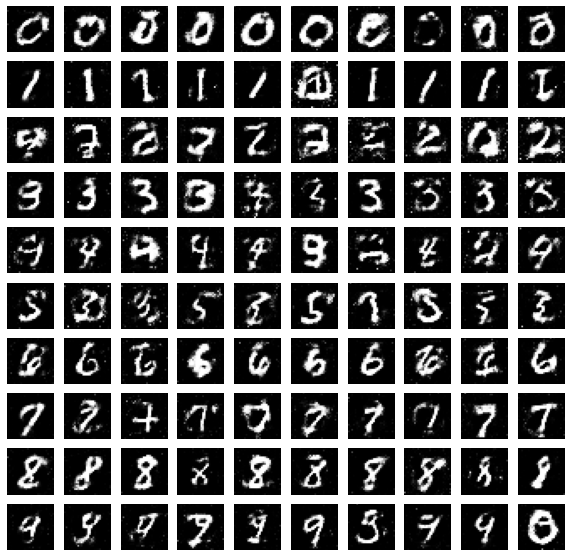

In [54]:
def plot_images(data, labels, mod, lammbda):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        indexes = np.where(labels == i)[0][:10]
        df = np.array([data[idx] for idx in indexes])
        df_labels = np.array([labels[idx] for idx in indexes])
        processed_df, df, lbls = preprocess(df, df_labels)
        for j in range(10):
            ax=plt.subplot2grid((10, 10), (i, j))
            z = np.random.normal(0,1,(1, 100))
            gen_image = mod.predict(np.concatenate([z, np.expand_dims(processed_df[j], 0)], axis=1))
            gen_image = 0.5*gen_image + 0.5
            try:
                ax.imshow(gen_image.reshape((28,28)), cmap='gray')
            except:
                pass
            plt.axis('off')
    print(f"For Lambda {lammbda}")
    plt.show()

plot_images(train_imgs_pri, np.argmax(train_labels, 1), generator, 10)

(100, 100)


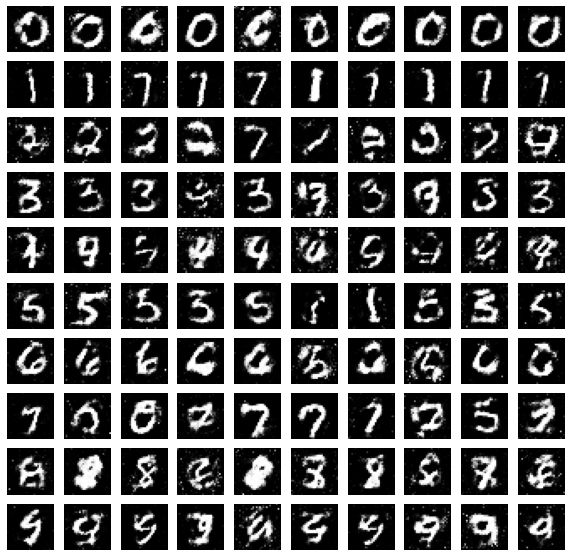

In [ ]:
def plot_images(data, labels, mod, lammbda):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        indexes = np.where(labels == i)[0][:10]
        df = np.array([data[idx] for idx in indexes])
        df_labels = np.array([labels[idx] for idx in indexes])
        processed_df, df, lbls = preprocess(df, df_labels)
        for j in range(10):
            ax=plt.subplot2grid((10, 10), (i, j))
            z = np.random.normal(0,1,(1, 100))
            gen_image = mod.predict(np.concatenate([z, np.expand_dims(processed_df[j], 0)], axis=1))
            gen_image = 0.5*gen_image + 0.5
            try:
                ax.imshow(gen_image.reshape((28,28)), cmap='gray')
            except:
                pass
            plt.axis('off')
    print(f"For Lambda {lammbda}")
    plt.show()

plot_images(train_imgs_pri, np.argmax(train_labels, 1), generator, 10)